In [4]:
import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string


from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing

#####################################################
#os.system('python 22_05_Transform_columns.py')
#No puedo ponerlo asi por que entonces dice que no esta definido df
#Seguro que hay alguna manera
#####################################################

path = "../../july_reduced copia.csv"
# This file is a CSV, just no CSV extension or headers
df_not_chunk = pd.read_csv(path, header=None, chunksize=200000)

# def expand_categories(values):
    # result = []
    # s = values.value_counts()
    # t = float(len(values))
    # for v in s.index:
        # result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    # return "[{}]".format(",".join(result))
        
# def analyze(filename):
    # print()
    # print("Analyzing: {}".format(filename))
    # df = pd.read_csv(filename,encoding=ENCODING)
    # cols = df.columns.values
    # total = float(len(df))

    # print("{} rows".format(int(total)))
    # for col in cols:
        # uniques = df[col].unique()
        # unique_count = len(uniques)
        # if unique_count>100:
            # print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        # else:
            # print("** {}:{}".format(col,expand_categories(df[col])))
            # expand_categories(df[col])

# #analyze(path)



# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
	
#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low
		
#MINMAX 0 1
def min_max_0(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)



##########################CHUNKSIZE###################################################

#Each chunk is in a df format
for df in df_not_chunk:
    #si no imprime no funciona, da error en el print
    #print(df[0:2])
    #df_not_chunk = df
    #########################################################################################


    #print("Read {} rows.".format(len(df)))
    # df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
    df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)


    # The CSV file has no column heads, so add them
    df.columns = [
        'time',
        'duration',
        'sip',
        'dip',
        'source_port',
        'dest_port',
        'protocol',
        'flags',
        'forward_status',
        'type_service',
        'pack_exch',
        'bytes',
        'attack_tag'
    ]

    #print(df[0:3])

    ENCODING = 'utf-8'



    #LAS QUE YA SON NUMEROS --> no los normalizo de momento
    # encode_numeric_zscore(df, 'duration')
    # encode_numeric_zscore(df, 'source_port')
    # encode_numeric_zscore(df, 'dest_port')
    # encode_numeric_zscore(df, 'forward_status')
    # encode_numeric_zscore(df, 'type_service')
    # encode_numeric_zscore(df, 'pack_exch')
    # encode_numeric_zscore(df, 'bytes')

    df.drop('time', 1, inplace=True)

    encode_text_dummy(df, 'protocol')
    encode_text_dummy(df, 'flags')
    #encode_text_dummy(df, 'attack_tag')

    outcomes = encode_text_index(df, 'attack_tag')
    num_classes = len(outcomes)

    #Me crea una columna AL FINAL nueva con los valores transformdos asi 20160318105240
    #df['time'] = df['time'].apply(clean_date)

    df['sip'] = df['sip'].apply(clean_ip)
    df['dip'] = df['dip'].apply(clean_ip)

    #encode_numeric_zscore(df, 'time')
    min_max_1(df, 'sip')
    min_max_1(df, 'dip')


    print(df.shape)
    print(df[0:3])


    ##################################################
    # Break into X (predictors) & y (prediction)
    x, y = to_xy(df,'attack_tag')
    #################################################



    # Create a test/train split.  25% test
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=42)

    # Create neural net
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(y.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    #model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=500)



    # Measure accuracy
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    cm = confusion_matrix(y_eval, pred)
    print(cm)

(200000, 37)
   duration       sip       dip  source_port  dest_port  forward_status  \
0    48.380 -0.852707 -0.996695           53         53               0   
1    48.380 -0.996694 -0.852728           53         53               0   
2    50.632 -0.669154 -0.512604           80       1838               0   

   type_service  pack_exch  bytes  attack_tag  ...  flags-.A.RS.  \
0             0          2    209           0  ...             0   
1             0          2    167           0  ...             0   
2             0          9   2082           0  ...             0   

   flags-.A.RSF  flags-.AP...  flags-.AP..F  flags-.AP.S.  flags-.AP.SF  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             1             0             0             0   

   flags-.APR..  flags-.APR.F  flags-.APRS.  flags-.APRSF  
0             0             0             0         

KeyboardInterrupt: 

In [6]:
# Compute confusion matrix
cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, products)

Confusion matrix, without normalization
[[49903     0]
 [   97     0]]


NameError: name 'plot_confusion_matrix' is not defined

<Figure size 432x288 with 0 Axes>

In [7]:
print(outcomes)

['background' 'blacklist']


Confusion matrix, without normalization
[[49903     0]
 [   97     0]]


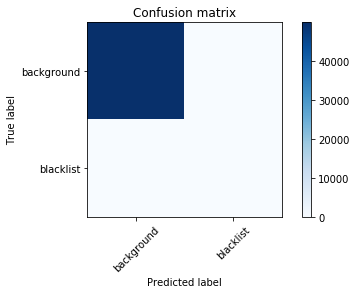

In [8]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_eval, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, outcomes)

In [9]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, products, title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


NameError: name 'products' is not defined

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


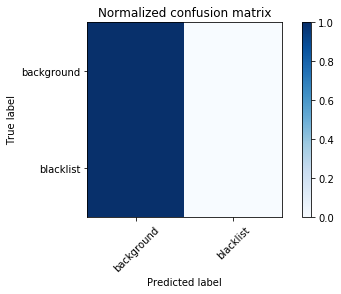

In [10]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

plt.show()

In [11]:
print(outcomes)

['background' 'blacklist']


In [12]:
import pandas as pd
import io
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import tensorflow.contrib.learn as skflow
import string
import Gnuplot as gp

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn import preprocessing


path = "../../july_reduced copia.csv"
# This file is a CSV, just no CSV extension or headers
df_not_chunk = pd.read_csv(path, header=None, chunksize=600000)


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#Clean 'date' column and convert to Int type
def clean_date(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_removed = s.replace(" ", "")
    s_int = int(s_removed)
    return s_int

########## CLEAN IP #######################
def clean_ip(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    s_int = int(s)
    return s_int

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

#MINMAX -1 1
# Encode a column to a range between normalized_low and normalized_high.
def min_max_1(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

#MINMAX 0 1
def min_max_0(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##########################CHUNKSIZE###################################################

#Each chunk is in a df format
for df in df_not_chunk:
    #si no imprime no funciona, da error en el print
    #print(df[0:2])
    #df_not_chunk = df
    #########################################################################################


    #print("Read {} rows.".format(len(df)))
    # df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
    df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)


    # The CSV file has no column heads, so add them
    df.columns = [
        'time',
        'duration',
        'sip',
        'dip',
        'source_port',
        'dest_port',
        'protocol',
        'flags',
        'forward_status',
        'type_service',
        'pack_exch',
        'bytes',
        'attack_tag'
    ]

    #print(df[0:3])

    ENCODING = 'utf-8'



    #LAS QUE YA SON NUMEROS --> no los normalizo de momento
    # encode_numeric_zscore(df, 'duration')
    # encode_numeric_zscore(df, 'source_port')
    # encode_numeric_zscore(df, 'dest_port')
    # encode_numeric_zscore(df, 'forward_status')
    # encode_numeric_zscore(df, 'type_service')
    # encode_numeric_zscore(df, 'pack_exch')
    # encode_numeric_zscore(df, 'bytes')

    df.drop('time', 1, inplace=True)

    encode_text_dummy(df, 'protocol')
    encode_text_dummy(df, 'flags')
    #encode_text_dummy(df, 'attack_tag')

    outcomes = encode_text_index(df, 'attack_tag')
    num_classes = len(outcomes)

    #Me crea una columna AL FINAL nueva con los valores transformdos asi 20160318105240
    #df['time'] = df['time'].apply(clean_date)

    df['sip'] = df['sip'].apply(clean_ip)
    df['dip'] = df['dip'].apply(clean_ip)

    #encode_numeric_zscore(df, 'time')
    minmax_0(df, 'sip')
    encode_numeric_zscore(df, 'dip')


    print(df.shape)
    print(df[0:3])


    ##################################################
    # Break into X (predictors) & y (prediction)
    x, y = to_xy(df,'attack_tag')
    #################################################



    # Create a test/train split.  25% test
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=42)

    # Create neural net
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Dense(y.shape[1],activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
    

    # Measure accuracy
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    
    print(outcomes)
    
    # Not normalized
    cm = confusion_matrix(y_eval, pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, outcomes)
    
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    gp.figure()
    plot_confusion_matrix(cm_normalized, outcomes, title='Normalized confusion matrix')

    gp.show()

ModuleNotFoundError: No module named 'Gnuplot'